# Описание проекта
Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 

# Подготовка рабочей среды

## Подключим необходимые библиотеки.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

## Настроим pandas и зугрузим наш датасет.

In [69]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

math = pd.read_csv('data/stud_math.csv')

## Опишем вспомогательные функции, которые пригодятся в будущем.

In [70]:
def describe_numeric(df, hist=True, corr=True):
    print(df.describe())
    print('\nУникальные значения:', df.unique())
    nan_count = len(math) - df.count()
    if nan_count > 0:
        print('\nЗаписи без данных графе "{}": {}'.format(df.name, nan_count))
        print('\nНеинформативные для критерия "{}" записи:'.format(df.name))
        display(math.loc[math[df.name].isnull()])
    else:
        print('\nНеинформативные для критерия "{}" записи отсутствуют.'.format(df.name))

    if hist:
        sns.jointplot(x=df.name, y='score', data=math, kind='reg')

    if corr:
        print('\nКорреляция со столбцом "score"', math.score.corr(math[df.name]))
    

In [71]:
def get_boxplot(column, coef=None):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x = column, y = 'score', data = math)
    title = 'Boxplot for column "{}"'.format(column)
    if coef is not None:
        title = '{} coef: {}'.format(title, coef)
    ax.set_title(title)
    plt.show()

In [72]:
def describe_nominal(df):
    print(df.describe())
    print(df.value_counts())
    null_count = len(math) - df.count()
    if null_count > 0:
        print('\nЗаписи без данных графе "{}": {}'.format(df.name, null_count))
        print('\nНеинформативные для критерия "{}" записи:'.format(df.name))
        display(math.loc[math[df.name].isnull()])
    else:
        print('\nНеинформативные для критерия "{}" записи отсутствуют.'.format(df.name))
    get_boxplot(df.name)

# Первичный осмотр данных

## Нормализация данных
Изучим названия колонок датасэта.

In [73]:
display(math.columns)

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

Нормализуем названия колонок и сделаем их названия более информативными.

In [74]:

math.columns = ['school', 'sex', 'age', 'address', 'family_size', 'parents_status', 'mother_education', 'father_education',
        'mother_job', 'father_job', 'school_selection_reason', 'guardian', 'travel_time', 'study_time', 'failures',
        'school_support', 'family_support', 'paid', 'activities', 'nursery', 'study_time_granular', 'higher', 'internet',
        'romantic', 'family_relations', 'free_time', 'go_out', 'health', 'absences', 'score']
display(math.columns)

Index(['school', 'sex', 'age', 'address', 'family_size', 'parents_status',
       'mother_education', 'father_education', 'mother_job', 'father_job',
       'school_selection_reason', 'guardian', 'travel_time', 'study_time',
       'failures', 'school_support', 'family_support', 'paid', 'activities',
       'nursery', 'study_time_granular', 'higher', 'internet', 'romantic',
       'family_relations', 'free_time', 'go_out', 'health', 'absences',
       'score'],
      dtype='object')

## Описание датасета
Посмотрим на данные, которые содержит датасет:

1 `school` — аббревиатура школы, в которой учится ученик

2 `sex` — пол ученика ('F' - женский, 'M' - мужской)

3 `age` — возраст ученика (от 15 до 22)

4 `address` — тип адреса ученика ('U' - городской, 'R' - за городом)

5 `family_size` — размер семьи('LE3' <= 3, 'GT3' >3)

6 `parents_status` — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

7 `mother_education` — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

8 `father_education` — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

9 `mother_job` — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

10 `father_job` — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

11 `school_selection_reason` — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

12 `guardian` — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

13 `travel_time` — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

14  `study_time` — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

15 `failures` — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

16 `school_support` — дополнительная образовательная поддержка (yes или no)

17 `family_support` — семейная образовательная поддержка (yes или no)

18 `paid` — дополнительные платные занятия по математике (yes или no)

19 `activities` — дополнительные внеучебные занятия (yes или no)

20 `nursery` — посещал детский сад (yes или no)

21 `higher` — хочет получить высшее образование (yes или no)

22 `internet` — наличие интернета дома (yes или no)

23 `romantic` — в романтических отношениях (yes или no)

24 `family_relations` — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

25 `free_time` — свободное время после школы (от 1 - очень мало до 5 - очень мого)

26 `go_out` — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

27 `health` — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

28 `absences` — количество пропущенных занятий

29 `score` — баллы по госэкзамену по математике



## Первичный анализ данных в столбцах
Изучим информацию о данных датасета.

In [75]:
math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   school                   395 non-null    object 
 1   sex                      395 non-null    object 
 2   age                      395 non-null    int64  
 3   address                  378 non-null    object 
 4   family_size              368 non-null    object 
 5   parents_status           350 non-null    object 
 6   mother_education         392 non-null    float64
 7   father_education         371 non-null    float64
 8   mother_job               376 non-null    object 
 9   father_job               359 non-null    object 
 10  school_selection_reason  378 non-null    object 
 11  guardian                 364 non-null    object 
 12  travel_time              367 non-null    float64
 13  study_time               388 non-null    float64
 14  failures                 3

Как можно увидеть, многие столбцы содержат отсутствующие данные. Рассчитаем процент пустых данных по каждому столбцу.

In [76]:
nas = round(math.isnull().sum() * 100 / len(math), 1)
display(nas.sort_values())

school                      0.0
sex                         0.0
age                         0.0
mother_education            0.8
score                       1.5
study_time_granular         1.8
study_time                  1.8
go_out                      2.0
school_support              2.3
free_time                   2.8
absences                    3.0
activities                  3.5
health                      3.8
nursery                     4.1
address                     4.3
school_selection_reason     4.3
mother_job                  4.8
higher                      5.1
failures                    5.6
father_education            6.1
family_relations            6.8
family_size                 6.8
travel_time                 7.1
guardian                    7.8
romantic                    7.8
internet                    8.6
father_job                  9.1
family_support              9.9
paid                       10.1
parents_status             11.4
dtype: float64

В большинстве столбцов количество отсутствующих данных не превышает 10%

Лишь два столбца имеют более 10% пустых значений это:
* paid (10.1)
* parents_status (11.4)

Пока что эти данные нам ни о чем не говорят, но будем держать их в голове.

Разделим данные на две группы:

* числовые переменные
* категориальные переменные

а после приступим к анализу каждой группы.

In [77]:
numeric_columns = math.select_dtypes(include=['int64', 'float64']).columns
print('Числовые признаки:\n', numeric_columns.values)

nominative_columns = math.select_dtypes(include='object').columns
print('\nКатегориальные признаки:\n', nominative_columns.values)

Числовые признаки:
 ['age' 'mother_education' 'father_education' 'travel_time' 'study_time'
 'failures' 'study_time_granular' 'family_relations' 'free_time' 'go_out'
 'health' 'absences' 'score']

Категориальные признаки:
 ['school' 'sex' 'address' 'family_size' 'parents_status' 'mother_job'
 'father_job' 'school_selection_reason' 'guardian' 'school_support'
 'family_support' 'paid' 'activities' 'nursery' 'higher' 'internet'
 'romantic']


## Первичный анализ данных числовых значений

## `score`
Самым важным полем для анализа явдяется поле `score` содеращее баллы по госэкзамену по математике. Именно его корреляцию с остальными полями мы и будем искать.

In [78]:
describe_numeric(math.score, hist=False, corr=False)

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Уникальные значения: [ 30.  50.  75.  55.  95.  45.  60.  70.  80.  25.  40.  85.  90.  65.
 100.  35.   0.  nan  20.]

Записи без данных графе "score": 6

Неинформативные для критерия "score" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,study_time_granular,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
201,GP,F,16,U,GT3,T,2.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,yes,yes,NaN,yes,yes,-6.0,yes,no,no,4.0,NaN,3.0,4.0,6.0,NaN
244,GP,F,18,U,GT3,T,2.0,1.0,other,other,course,other,2.0,3.0,0.0,no,yes,yes,no,no,-9.0,yes,yes,yes,4.0,4.0,4.0,3.0,0.0,NaN
270,GP,F,19,NaN,GT3,T,3.0,3.0,other,services,home,other,1.0,2.0,2.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,3.0,5.0,5.0,NaN,NaN
283,GP,F,18,U,GT3,T,1.0,1.0,other,other,home,mother,2.0,2.0,0.0,yes,NaN,no,yes,yes,-6.0,yes,yes,no,5.0,NaN,4.0,4.0,4.0,NaN
312,GP,M,19,U,GT3,T,1.0,2.0,other,services,course,other,1.0,2.0,1.0,no,no,no,no,no,-6.0,yes,yes,no,4.0,5.0,NaN,4.0,3.0,NaN
350,MS,M,19,NaN,GT3,T,1.0,1.0,other,services,home,other,3.0,2.0,3.0,no,no,no,no,NaN,-6.0,yes,yes,no,5.0,4.0,4.0,2.0,8.0,NaN


Записи, в которых отсутсвуют данные о рейтинге учащегося неинформатины для нас и будут лишь загрязнять основную выборку. Избавимся от них на начальном этапе.

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Уникальные значения: [ 30.  50.  75.  55.  95.  45.  60.  70.  80.  25.  40.  85.  90.  65.
 100.  35.   0.  20.]

Неинформативные для критерия "score" записи отсутствуют.


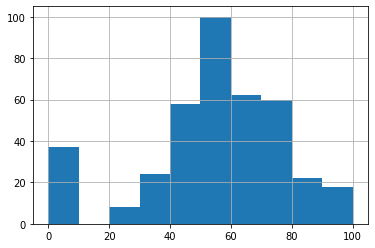

In [79]:
math = math.dropna(subset=['score'])
describe_numeric(math.score, hist=False, corr=False)
math.score.hist()

Так же на графике видно определенное количество записей со значением 0 баллов. За ними следует 'провал' до 20, далее значения увеличиваются с шагом 5 и доходят до 100. Можно предположить, что это проценты. Так же можно предположить, что 20 - мнимальный балл, который модно получить.
Посчитаем процент значений с оценкой в 0 баллов.


In [80]:
zeros = len(math.loc[math.score == 0])
print('Колличество записей с 0 баллов {} это {}% от всего датасета'.format(zeros, round(zeros / len(math) * 100, 2)))

Колличество записей с 0 баллов 37 это 9.51% от всего датасета


Взглянем на эти данные более детально:

In [81]:
display(math.loc[math.score == 0])

,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,study_time_granular,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,-3.0,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
130,GP,F,15,R,GT3,T,3.0,4.0,services,teacher,course,father,2.0,3.0,2.0,no,yes,no,no,yes,-9.0,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,0.0
131,GP,F,15,U,GT3,NaN,1.0,1.0,at_home,other,course,mother,3.0,1.0,0.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
134,GP,M,15,R,GT3,T,3.0,4.0,at_home,teacher,course,mother,NaN,2.0,0.0,no,yes,no,no,yes,-6.0,yes,no,yes,5.0,3.0,3.0,5.0,0.0,0.0
135,GP,F,15,U,GT3,T,4.0,4.0,services,NaN,course,mother,1.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,yes,4.0,3.0,3.0,5.0,0.0,0.0
136,GP,M,17,R,GT3,T,3.0,4.0,at_home,other,course,mother,3.0,2.0,0.0,no,no,NaN,no,yes,-6.0,yes,no,no,NaN,4.0,5.0,5.0,0.0,0.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,-12.0,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,home,NaN,1.0,1.0,3.0,no,yes,no,no,yes,-3.0,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0
146,GP,F,15,U,GT3,T,3.0,2.0,health,services,home,father,1.0,2.0,3.0,no,NaN,no,no,yes,-6.0,yes,yes,no,3.0,3.0,2.0,3.0,0.0,0.0


Это могут быть люди неявившиесь или недопущеные к экзамену либо ошибки ввода.

Как интерпритировать эти данные непонятно. 

## `age`
возраст ученика (от 15 до 22)

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

Уникальные значения: [18 17 15 16 19 22 20 21]

Неинформативные для критерия "age" записи отсутствуют.

Корреляция со столбцом "score" -0.1557262607741256


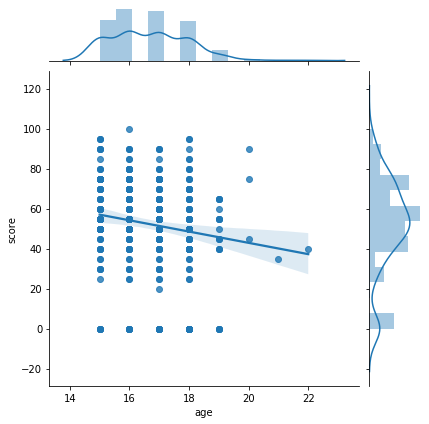

In [82]:
describe_numeric(math.age, hist=True, corr=True)

Пропущеных значений и выбросов в данном столбце не наблюдаем. Все данные находятся в описанном в задаче промежутке от 15 до 22 лет.
Исходя из графика и коэфициента корреляции с возрастом успеваемость падает. 

## `mother_education`
образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

count    386.000000
mean       2.766839
std        1.094277
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: mother_education, dtype: float64

Уникальные значения: [ 4.  1.  3.  2. nan  0.]

Записи без данных графе "mother_education": 3

Неинформативные для критерия "mother_education" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,study_time_granular,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
92,GP,F,16,NaN,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
193,GP,M,16,R,GT3,NaN,NaN,3.0,services,services,reputation,mother,1.0,1.0,0.0,no,yes,no,yes,yes,-3.0,yes,yes,no,4.0,3.0,2.0,5.0,8.0,50.0
239,GP,M,18,U,GT3,NaN,NaN,2.0,other,services,reputation,father,1.0,2.0,1.0,no,no,no,no,yes,-6.0,no,NaN,NaN,5.0,5.0,4.0,2.0,0.0,0.0



Корреляция со столбцом "score" 0.2133487237506019


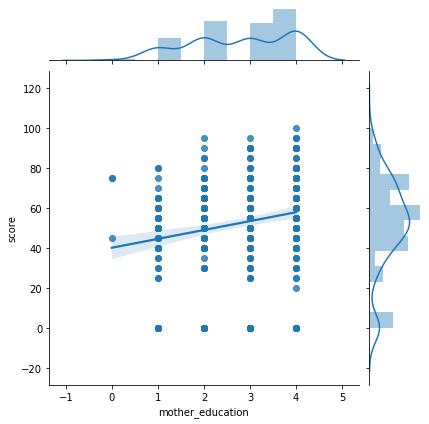

In [83]:
describe_numeric(math.mother_education, hist=True, corr=True)

В столбце есть 3 пропуска, заполнить их мы не можем.
Остальные данные лежат в промежутке указанном в условии задачи. 

Взглянув на график и коэфициент корреляции приходим к следующим выводам:
* большинство матерей имеют как минимум, среднее образование.
* образование матери достаточно сильно влияет на успехи ребенка, чем выше образование матери - тем выше результат на экзамене.

## `father_education`
образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

count    365.000000
mean       2.627397
std        2.241790
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       40.000000
Name: father_education, dtype: float64

Уникальные значения: [ 4.  1.  2.  3. 40. nan  0.]

Записи без данных графе "father_education": 24

Неинформативные для критерия "father_education" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,study_time_granular,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
21,GP,M,15,U,GT3,T,4.0,NaN,health,health,other,father,1.0,1.0,NaN,no,yes,NaN,no,yes,-3.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
42,GP,M,15,U,GT3,T,4.0,NaN,services,teacher,course,father,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,2.0,90.0
46,GP,F,16,U,LE3,A,3.0,NaN,other,services,home,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,5.0,3.0,12.0,55.0
57,GP,M,15,U,GT3,T,4.0,NaN,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,no,no,3.0,2.0,2.0,5.0,4.0,75.0
58,GP,M,15,U,LE3,T,1.0,NaN,other,at_home,home,father,1.0,2.0,0.0,yes,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,2.0,5.0,2.0,45.0
67,GP,F,16,U,GT3,NaN,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
142,GP,F,15,U,GT3,T,4.0,NaN,teacher,services,course,mother,NaN,3.0,0.0,no,yes,yes,yes,yes,-9.0,NaN,yes,no,4.0,2.0,2.0,5.0,2.0,55.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
161,GP,M,15,R,GT3,T,3.0,NaN,other,NaN,course,mother,2.0,2.0,2.0,yes,yes,no,no,yes,-6.0,yes,yes,yes,4.0,4.0,4.0,3.0,6.0,35.0



Корреляция со столбцом "score" 0.07857258767789257


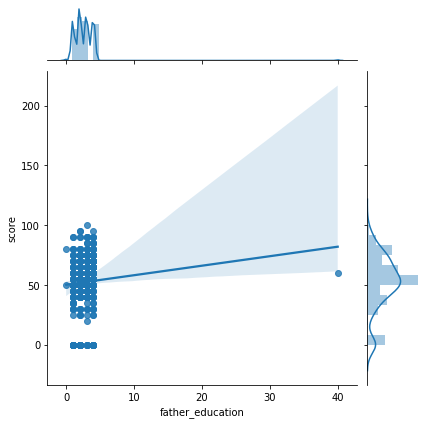

In [84]:
describe_numeric(math.father_education, hist=True, corr=True)

В столбце есть пропуски, заполнить их мы не можем, так как не достаточно данных для выделения значения которым заполнять.
На графике четко виден выброс со значением 40, взглянем на него внимательнее.

In [85]:
math.loc[math.father_education == 40]

,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,study_time_granular,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


Остальные поля заполнены правильно, удалять запись смысла не вижу. Будем считать это опечаткой, и зполним значением NaN. Есть шанс, что хотели написать 4, а получилось 40, но достоверно сказать этого нельзя.

In [86]:
math.at[11, 'father_education'] = np.NaN

После очистки выброса взглянем на данные более детально:

count    364.000000
mean       2.524725
std        1.086833
min        0.000000
25%        2.000000
50%        2.500000
75%        3.000000
max        4.000000
Name: father_education, dtype: float64

Уникальные значения: [ 4.  1.  2.  3. nan  0.]

Записи без данных графе "father_education": 25

Неинформативные для критерия "father_education" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,study_time_granular,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,NaN,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0
21,GP,M,15,U,GT3,T,4.0,NaN,health,health,other,father,1.0,1.0,NaN,no,yes,NaN,no,yes,-3.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
42,GP,M,15,U,GT3,T,4.0,NaN,services,teacher,course,father,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,2.0,90.0
46,GP,F,16,U,LE3,A,3.0,NaN,other,services,home,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,5.0,3.0,12.0,55.0
57,GP,M,15,U,GT3,T,4.0,NaN,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,no,no,3.0,2.0,2.0,5.0,4.0,75.0
58,GP,M,15,U,LE3,T,1.0,NaN,other,at_home,home,father,1.0,2.0,0.0,yes,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,2.0,5.0,2.0,45.0
67,GP,F,16,U,GT3,NaN,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
142,GP,F,15,U,GT3,T,4.0,NaN,teacher,services,course,mother,NaN,3.0,0.0,no,yes,yes,yes,yes,-9.0,NaN,yes,no,4.0,2.0,2.0,5.0,2.0,55.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0



Корреляция со столбцом "score" 0.13000241226048262


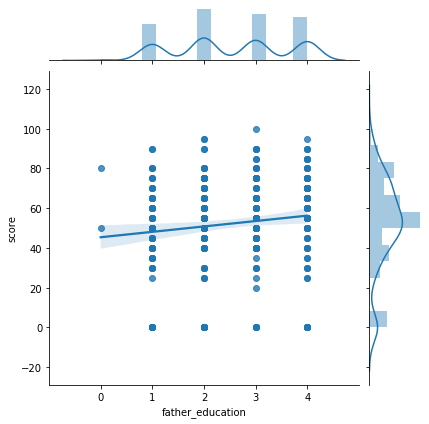

In [87]:
describe_numeric(math.father_education, hist=True, corr=True)

Взглянув на график и коэфициент корреляции приходими к следующим выводам:

* большая часть отцов имеет как минимум, среднее образование.
* образование отца так же положительно влияет на успеваемость ребенка, но не так сильно, как образование матери.

## `travel_time`
время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

count    361.000000
mean       1.434903
std        0.692660
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: travel_time, dtype: float64

Уникальные значения: [ 2.  1.  3. nan  4.]

Записи без данных графе "travel_time": 28

Неинформативные для критерия "travel_time" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,study_time_granular,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
26,GP,M,15,U,GT3,T,2.0,2.0,other,NaN,home,mother,NaN,1.0,0.0,no,yes,NaN,no,yes,-3.0,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0
30,GP,M,15,U,GT3,T,4.0,4.0,health,services,home,mother,NaN,2.0,0.0,no,yes,yes,no,no,-6.0,yes,yes,no,5.0,4.0,2.0,NaN,0.0,60.0
35,GP,F,15,U,GT3,T,2.0,3.0,other,other,other,father,NaN,1.0,0.0,NaN,yes,no,yes,yes,-3.0,yes,no,no,3.0,5.0,1.0,5.0,0.0,30.0
37,GP,M,16,R,GT3,A,4.0,4.0,other,teacher,reputation,mother,NaN,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,yes,2.0,4.0,3.0,5.0,7.0,75.0
59,GP,F,16,U,GT3,T,4.0,2.0,NaN,NaN,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,-6.0,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,NaN,reputation,mother,NaN,2.0,NaN,yes,yes,NaN,no,yes,-6.0,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0
70,GP,M,16,U,GT3,T,3.0,1.0,other,other,reputation,father,NaN,4.0,0.0,no,yes,yes,no,yes,-12.0,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
104,GP,M,15,U,GT3,A,3.0,4.0,NaN,other,course,mother,NaN,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,yes,no,5.0,4.0,4.0,1.0,0.0,90.0
112,GP,F,16,U,GT3,NaN,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,yes,no,no,yes,yes,NaN,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0
132,GP,F,17,U,LE3,T,2.0,2.0,other,other,course,father,NaN,1.0,0.0,no,yes,no,no,yes,-3.0,yes,NaN,yes,3.0,4.0,4.0,5.0,12.0,60.0



Корреляция со столбцом "score" -0.07055876916148832


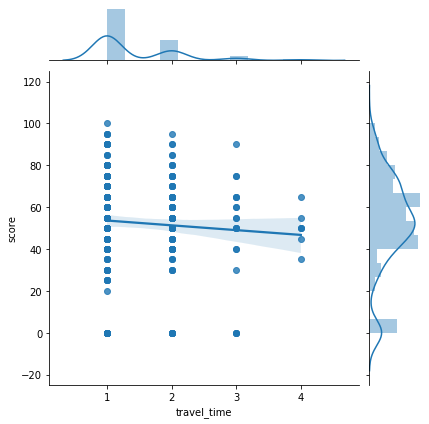

In [88]:
describe_numeric(math.travel_time, hist=True, corr=True)

В данных есть пропуски, заполнить их нет возможности.

Взглянув на график и коэфициент корреляции приходими к следующим выводам:
* большинство учащихся тратят на дорогу не больше 15 минут
* увеличение времени проводимого в пути в школу и обратно негативно влияет на успеваемость

## `study_time`
время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

count    382.000000
mean       2.036649
std        0.847239
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: study_time, dtype: float64

Уникальные значения: [ 2.  3.  1. nan  4.]

Записи без данных графе "study_time": 7

Неинформативные для критерия "study_time" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,study_time_granular,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
17,GP,F,16,U,GT3,T,3.0,3.0,other,NaN,reputation,mother,3.0,NaN,0.0,yes,NaN,no,yes,yes,NaN,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0
91,GP,F,15,U,GT3,T,4.0,3.0,services,other,reputation,mother,1.0,NaN,NaN,no,no,yes,yes,yes,NaN,yes,yes,no,4.0,5.0,5.0,1.0,4.0,90.0
112,GP,F,16,U,GT3,NaN,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,yes,no,no,yes,yes,NaN,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0
227,GP,M,17,U,LE3,NaN,2.0,3.0,services,services,reputation,father,1.0,NaN,0.0,no,yes,yes,no,no,NaN,NaN,yes,no,5.0,3.0,3.0,3.0,NaN,60.0
266,GP,M,17,U,GT3,NaN,3.0,1.0,services,NaN,other,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,NaN,5.0,4.0,4.0,NaN,2.0,50.0
314,GP,F,19,U,GT3,T,1.0,1.0,at_home,health,home,other,1.0,NaN,2.0,no,no,no,no,no,NaN,yes,yes,yes,4.0,NaN,2.0,3.0,14.0,65.0



Корреляция со столбцом "score" 0.11574134847030247


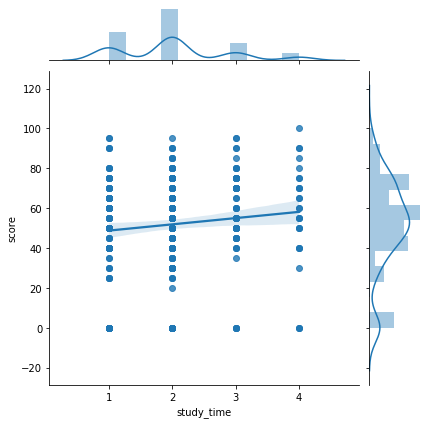

In [89]:
describe_numeric(math.study_time, hist=True, corr=True)

В данных есть пропуски, заполнить их нет возможности.

Взглянув на график и коэфициент корреляции приходими к следующим выводам:
* большиство обучающихся тратит на учебу помимо школы еще от 2 до 5ти часов.
* увеличение времени на дополнительное обучение положительно влияет на успеваемость.

## `study_time_granular`
в описании задачи данный столбец отсутствует, из названия можно предположить что эта информация связана со столбцом study_time. Проверим кореллируют ли они.

Значение корелляции: -0.9999999999999993


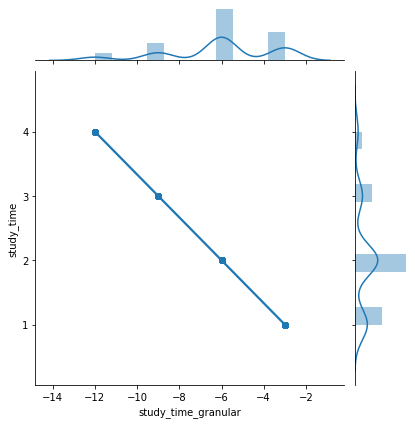

In [90]:
corr = math.study_time.corr(math.study_time_granular)
print('Значение корелляции:', corr)
sns.jointplot(x = 'study_time_granular', y = 'study_time', data = math, kind = 'reg')

Как видно из значения, study_time_granular и study_time имеют обратную кореляцию. В чем можно убедиться на графике.

Так, как новых полезных данных информация в столбце study_time_granular нам не дает, избавимся от него.

In [91]:
math.drop(['study_time_granular'], inplace = True, axis = 1)
math.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   school                   389 non-null    object 
 1   sex                      389 non-null    object 
 2   age                      389 non-null    int64  
 3   address                  374 non-null    object 
 4   family_size              362 non-null    object 
 5   parents_status           344 non-null    object 
 6   mother_education         386 non-null    float64
 7   father_education         364 non-null    float64
 8   mother_job               370 non-null    object 
 9   father_job               353 non-null    object 
 10  school_selection_reason  372 non-null    object 
 11  guardian                 358 non-null    object 
 12  travel_time              361 non-null    float64
 13  study_time               382 non-null    float64
 14  failures                 3

## `failures`
failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)


In [92]:
describe_numeric(math.failures, hist=True, corr=True)

count    367.000000
mean       0.326975
std        0.729479
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

Уникальные значения: [ 0.  3. nan  2.  1.]

Записи без данных графе "failures": 22

Неинформативные для критерия "failures" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
21,GP,M,15,U,GT3,T,4.0,NaN,health,health,other,father,1.0,1.0,NaN,no,yes,NaN,no,yes,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
48,GP,M,15,U,GT3,T,4.0,2.0,teacher,other,home,mother,1.0,2.0,NaN,no,yes,yes,no,yes,NaN,no,no,4.0,3.0,3.0,5.0,2.0,70.0
54,GP,F,15,U,LE3,NaN,3.0,3.0,NaN,other,other,mother,1.0,1.0,NaN,no,no,yes,NaN,yes,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,NaN,reputation,mother,NaN,2.0,NaN,yes,yes,NaN,no,yes,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0
91,GP,F,15,U,GT3,T,4.0,3.0,services,other,reputation,mother,1.0,NaN,NaN,no,no,yes,yes,yes,yes,yes,no,4.0,5.0,5.0,1.0,4.0,90.0
107,GP,M,16,U,GT3,T,3.0,3.0,services,NaN,home,father,1.0,3.0,NaN,no,yes,no,yes,yes,yes,yes,no,5.0,3.0,3.0,5.0,2.0,90.0
108,GP,M,15,R,GT3,NaN,4.0,4.0,other,other,home,father,4.0,4.0,NaN,no,yes,yes,yes,yes,yes,yes,yes,1.0,3.0,5.0,1.0,6.0,65.0
114,GP,M,15,R,NaN,T,2.0,1.0,health,services,reputation,mother,1.0,2.0,NaN,no,no,no,yes,yes,yes,yes,yes,5.0,4.0,2.0,5.0,8.0,45.0
115,GP,M,16,U,GT3,T,4.0,4.0,teacher,teacher,course,father,1.0,2.0,NaN,no,yes,no,yes,yes,yes,NaN,no,5.0,4.0,4.0,5.0,2.0,80.0
125,GP,M,15,U,GT3,T,3.0,4.0,services,services,home,father,1.0,1.0,NaN,yes,no,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,0.0,60.0


RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

В столбце имеются пропуски. Остальные данные указывают на то, что подавляющее большинство учащихся не имеют внеучебных неудач (что бы это ни значило), а у остальных их не больше 3.

## `family_relations`
семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

count    362.000000
mean       3.930939
std        0.931554
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: family_relations, dtype: float64

Уникальные значения: [ 4.  5.  3. nan -1.  2.  1.]

Записи без данных графе "family_relations": 27

Неинформативные для критерия "family_relations" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
12,GP,M,15,U,LE3,T,4.0,4.0,health,services,course,father,1.0,1.0,0.0,no,yes,yes,yes,yes,yes,NaN,no,NaN,3.0,3.0,5.0,2.0,70.0
20,GP,M,15,U,GT3,T,4.0,3.0,teacher,other,reputation,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,yes,no,NaN,4.0,1.0,1.0,0.0,75.0
43,GP,M,15,U,GT3,T,2.0,2.0,services,services,course,father,1.0,1.0,0.0,yes,yes,no,NaN,yes,yes,yes,no,NaN,4.0,1.0,1.0,0.0,55.0
72,GP,F,15,R,GT3,T,1.0,1.0,other,other,reputation,mother,1.0,2.0,2.0,yes,yes,no,no,no,yes,yes,yes,NaN,3.0,4.0,5.0,2.0,25.0
73,GP,M,16,U,GT3,T,3.0,1.0,other,other,NaN,mother,1.0,1.0,0.0,no,no,no,yes,yes,yes,no,no,NaN,3.0,2.0,5.0,2.0,70.0
75,GP,M,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0
94,GP,M,15,U,LE3,T,2.0,2.0,services,health,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,yes,yes,yes,no,NaN,3.0,4.0,4.0,6.0,70.0
102,GP,M,15,U,GT3,T,4.0,4.0,services,other,course,mother,1.0,1.0,0.0,no,yes,no,yes,no,yes,yes,no,NaN,3.0,3.0,5.0,4.0,70.0
118,GP,M,17,R,GT3,T,1.0,3.0,other,NaN,course,father,3.0,2.0,1.0,no,yes,no,yes,yes,yes,NaN,no,NaN,2.0,4.0,5.0,20.0,40.0



Корреляция со столбцом "score" 0.057111802877168355


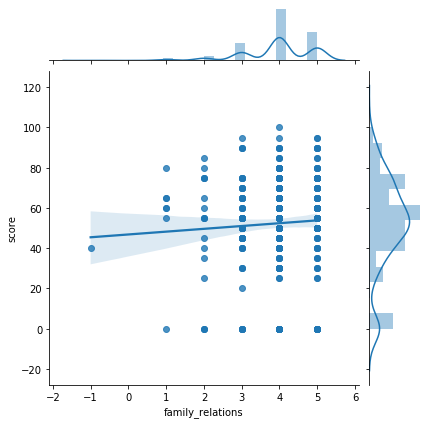

In [93]:
describe_numeric(math.family_relations, hist=True, corr=True)

В столбце есть пропуски, заполнить их мы не можем.
На графике четко виден выброс со значением -1, взглянем на него внимательнее.

In [94]:
math.loc[math.family_relations == -1]

,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


Остальные поля заполнены нормально, удалять запись смысла не вижу. Будем считать это опечаткой, и зполним значением NaN.

In [95]:
math.at[25, 'family_relations'] = np.NaN

После очистки выброса взглянем на данные более детально:

count    361.000000
mean       3.944598
std        0.895811
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: family_relations, dtype: float64

Уникальные значения: [ 4.  5.  3. nan  2.  1.]

Записи без данных графе "family_relations": 28

Неинформативные для критерия "family_relations" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
12,GP,M,15,U,LE3,T,4.0,4.0,health,services,course,father,1.0,1.0,0.0,no,yes,yes,yes,yes,yes,NaN,no,NaN,3.0,3.0,5.0,2.0,70.0
20,GP,M,15,U,GT3,T,4.0,3.0,teacher,other,reputation,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,yes,no,NaN,4.0,1.0,1.0,0.0,75.0
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,yes,yes,no,NaN,2.0,2.0,5.0,14.0,40.0
43,GP,M,15,U,GT3,T,2.0,2.0,services,services,course,father,1.0,1.0,0.0,yes,yes,no,NaN,yes,yes,yes,no,NaN,4.0,1.0,1.0,0.0,55.0
72,GP,F,15,R,GT3,T,1.0,1.0,other,other,reputation,mother,1.0,2.0,2.0,yes,yes,no,no,no,yes,yes,yes,NaN,3.0,4.0,5.0,2.0,25.0
73,GP,M,16,U,GT3,T,3.0,1.0,other,other,NaN,mother,1.0,1.0,0.0,no,no,no,yes,yes,yes,no,no,NaN,3.0,2.0,5.0,2.0,70.0
75,GP,M,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0
94,GP,M,15,U,LE3,T,2.0,2.0,services,health,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,yes,yes,yes,no,NaN,3.0,4.0,4.0,6.0,70.0
102,GP,M,15,U,GT3,T,4.0,4.0,services,other,course,mother,1.0,1.0,0.0,no,yes,no,yes,no,yes,yes,no,NaN,3.0,3.0,5.0,4.0,70.0



Корреляция со столбцом "score" 0.05121939353553732


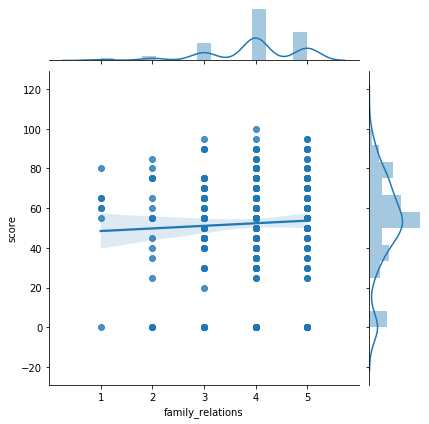

In [96]:
describe_numeric(math.family_relations, hist=True, corr=True)

Судя по оставшимся данным, делаем выводы что:
* большиство учащихся оценивают отношения в семье достаточно хорошо.
* хорошие отношения в семье также положительно влияют на успеваемость.

## `free_time`
свободное время после школы (от 1 - очень мало до 5 - очень много)

count    380.000000
mean       3.223684
std        0.993364
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: free_time, dtype: float64

Уникальные значения: [ 3.  2.  4.  1.  5. nan]

Записи без данных графе "free_time": 9

Неинформативные для критерия "free_time" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
32,GP,M,15,R,NaN,T,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,no,yes,no,yes,NaN,yes,yes,yes,4.0,NaN,2.0,5.0,0.0,80.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
131,GP,F,15,U,GT3,NaN,1.0,1.0,at_home,other,course,mother,3.0,1.0,0.0,no,yes,no,yes,no,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
280,GP,M,17,U,NaN,A,4.0,NaN,services,other,home,mother,2.0,1.0,NaN,no,no,yes,yes,yes,yes,yes,NaN,4.0,NaN,4.0,5.0,30.0,40.0
290,GP,M,18,U,GT3,T,4.0,NaN,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,NaN,NaN,NaN,2.0,5.0,11.0,55.0
291,GP,F,17,U,GT3,T,4.0,3.0,NaN,services,reputation,NaN,1.0,3.0,0.0,no,yes,yes,no,yes,yes,yes,no,4.0,NaN,2.0,3.0,0.0,75.0
311,GP,F,19,U,GT3,T,2.0,1.0,at_home,other,other,other,3.0,2.0,0.0,no,yes,no,no,yes,no,yes,yes,3.0,NaN,1.0,2.0,20.0,65.0
314,GP,F,19,U,GT3,T,1.0,1.0,at_home,health,home,other,1.0,NaN,2.0,no,no,no,no,no,yes,yes,yes,4.0,NaN,2.0,3.0,14.0,65.0
338,GP,F,18,U,LE3,T,3.0,3.0,services,services,home,mother,1.0,4.0,0.0,no,yes,no,no,yes,yes,yes,no,5.0,NaN,3.0,1.0,7.0,85.0



Корреляция со столбцом "score" 0.019026114857179168


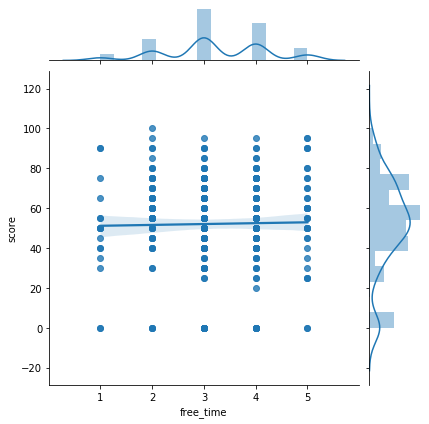

In [97]:
describe_numeric(math.free_time, hist=True, corr=True)

В столбце присутствуют пропуски, заполнить их мы не можем. 

По данным можно прийти к выводу, что:
* у большинства учащихся остается достаточно свободного времени.
* особо этот  показатель на успеваемость не влияет

## `go_out`
проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

count    382.000000
mean       3.094241
std        1.116104
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: go_out, dtype: float64

Уникальные значения: [ 4.  3.  2.  1.  5. nan]

Записи без данных графе "go_out": 7

Неинформативные для критерия "go_out" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
89,GP,M,16,U,LE3,A,4.0,4.0,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,no,no,yes,yes,no,no,4.0,1.0,NaN,5.0,18.0,35.0
92,GP,F,16,NaN,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
200,GP,F,16,U,GT3,T,4.0,3.0,health,other,home,mother,1.0,2.0,0.0,no,yes,NaN,yes,yes,yes,yes,no,4.0,3.0,NaN,2.0,2.0,80.0
202,GP,F,17,U,NaN,T,1.0,1.0,other,other,course,mother,1.0,2.0,0.0,no,yes,yes,no,no,yes,no,no,4.0,4.0,NaN,1.0,4.0,50.0
221,GP,F,17,U,NaN,T,1.0,1.0,at_home,other,reputation,mother,1.0,3.0,1.0,no,yes,no,yes,yes,yes,no,yes,4.0,3.0,NaN,5.0,0.0,0.0
241,GP,M,17,NaN,LE3,A,4.0,4.0,teacher,other,course,mother,NaN,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,3.0,3.0,NaN,4.0,2.0,60.0
322,GP,F,17,R,LE3,T,2.0,2.0,services,services,course,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,no,3.0,3.0,NaN,3.0,3.0,55.0



Корреляция со столбцом "score" -0.12968492760854372


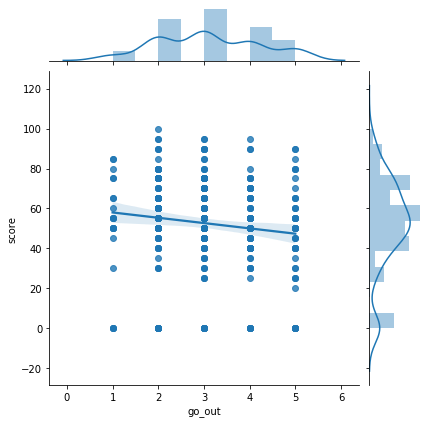

In [98]:
describe_numeric(math.go_out, hist=True, corr=True)

В столбце присутствуют пропуски, заполнить их мы не можем. 
По данным можно сделать вывод, что:
* большинство учащихся проводят достаточно много времени с друзьями
* время проведенное с друзьями пагубно сказывается на успеваемости.

## `health`
текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

count    374.000000
mean       3.529412
std        1.402006
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

Уникальные значения: [ 3.  5.  1.  2.  4. nan]

Записи без данных графе "health": 15

Неинформативные для критерия "health" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
30,GP,M,15,U,GT3,T,4.0,4.0,health,services,home,mother,NaN,2.0,0.0,no,yes,yes,no,no,yes,yes,no,5.0,4.0,2.0,NaN,0.0,60.0
55,GP,F,16,U,GT3,A,2.0,1.0,other,other,other,mother,1.0,2.0,0.0,no,no,yes,yes,yes,yes,yes,yes,5.0,3.0,4.0,NaN,8.0,50.0
88,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,reputation,father,2.0,2.0,1.0,no,no,yes,yes,NaN,yes,yes,no,4.0,4.0,2.0,NaN,12.0,50.0
145,GP,F,15,U,GT3,T,1.0,1.0,NaN,services,course,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,4.0,4.0,2.0,NaN,0.0,55.0
153,GP,M,19,U,GT3,NaN,3.0,2.0,services,at_home,home,mother,1.0,1.0,NaN,no,yes,no,no,yes,no,yes,yes,4.0,5.0,4.0,NaN,0.0,0.0
164,GP,M,17,R,LE3,T,1.0,1.0,other,services,course,NaN,4.0,2.0,3.0,no,no,NaN,yes,yes,no,no,yes,5.0,3.0,5.0,NaN,0.0,35.0
189,GP,M,17,R,GT3,T,1.0,2.0,at_home,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,no,no,3.0,1.0,3.0,NaN,4.0,50.0
208,GP,F,16,U,GT3,T,1.0,1.0,at_home,other,home,mother,2.0,1.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,NaN,6.0,50.0
220,GP,F,17,R,GT3,T,2.0,1.0,at_home,services,reputation,mother,2.0,2.0,0.0,no,yes,no,yes,yes,yes,yes,no,4.0,2.0,5.0,NaN,2.0,30.0
236,GP,M,17,U,LE3,T,2.0,NaN,other,other,home,father,1.0,2.0,NaN,no,no,NaN,yes,no,yes,yes,yes,4.0,4.0,2.0,NaN,4.0,65.0



Корреляция со столбцом "score" -0.07046016495946901


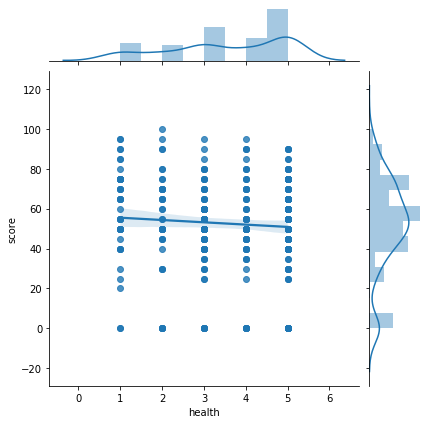

In [99]:
describe_numeric(math.health)

В столбце присутствуют пропуски, заполнить их мы не можем. 

Можно сделать заключение, что: 
* большинство учащихся чувствуют себя хорошо
* у детей, которые больше болеют успеваемость выше, скорее всего из-за того, что они больше времени проводят дома.

## `absences`
количество пропущенных занятий

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Уникальные значения: [  6.   4.  10.   2.   0.  16.  nan  14.   7.   8.  25.  12.  54.  18.
  26.  20.  56.  24.  28.   5.  13.  15.  22.   3. 385.  21.   1.  75.
  30.  19.   9.  11.  38.  40.  23.  17. 212.]

Записи без данных графе "absences": 11

Неинформативные для критерия "absences" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
24,GP,F,15,R,GT3,T,2.0,4.0,services,health,course,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,4.0,3.0,2.0,5.0,NaN,40.0
101,GP,M,16,U,GT3,T,4.0,4.0,services,teacher,other,father,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,yes,4.0,4.0,3.0,4.0,NaN,85.0
120,GP,F,15,U,GT3,T,1.0,2.0,at_home,NaN,course,mother,1.0,2.0,0.0,no,no,no,no,no,yes,yes,no,3.0,2.0,3.0,1.0,NaN,75.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0
150,GP,M,18,U,LE3,T,1.0,1.0,other,other,course,mother,1.0,1.0,3.0,no,no,no,no,yes,no,yes,yes,2.0,3.0,5.0,4.0,NaN,0.0
172,GP,M,17,U,NaN,T,4.0,4.0,teacher,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,4.0,4.0,4.0,5.0,NaN,50.0
215,GP,F,17,U,LE3,T,3.0,2.0,other,other,reputation,mother,2.0,2.0,0.0,no,no,NaN,no,yes,yes,NaN,no,4.0,4.0,4.0,1.0,NaN,75.0
227,GP,M,17,U,LE3,NaN,2.0,3.0,services,services,reputation,father,1.0,NaN,0.0,no,yes,yes,no,no,NaN,yes,no,5.0,3.0,3.0,3.0,NaN,60.0
254,GP,M,17,NaN,NaN,T,2.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,no,no,yes,yes,no,4.0,4.0,2.0,5.0,NaN,60.0
265,GP,M,18,R,LE3,NaN,3.0,4.0,NaN,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,4.0,2.0,5.0,1.0,NaN,85.0



Корреляция со столбцом "score" 0.0652829844188877


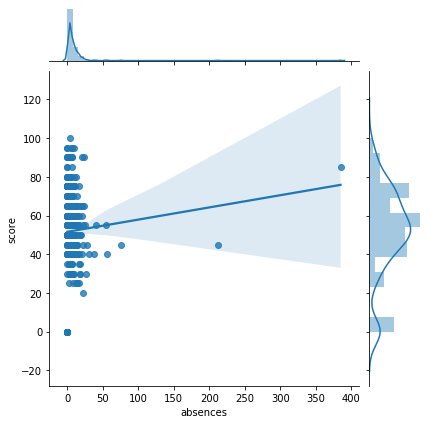

In [100]:
describe_numeric(math.absences)

На графике четко видны выброс аномальные значения 212 и 385, взглянем на них внимательнее.

In [101]:
math.loc[(math.absences == 212) | (math.absences == 385)]

,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0


Учащийся №222 с колличеством прогулов 385 имеет очень высокую оценку по математике 85 баллов. Что не свойственно для данной выборки и очень сильно влияет на результаты исследования. Графа с указанием места работы отца 'teacher' может немного прояснить ситуацию. Либо учащийся обучался вне школы, либо же имеет место подтасовка данных. 
Второй учащийся №390 тоже выглядит странно при 212 пропусках получил 45 баллов. Возможно вундеркинд, но все равно не вписывается в общую выборку.
Отметим эти данные как выбросы и удалим их.


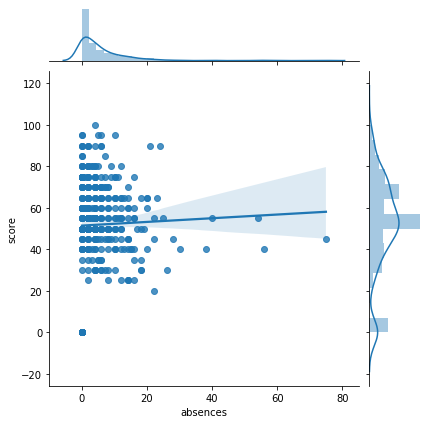

In [102]:
math = math.loc[(math.absences != 212) & (math.absences != 385)]
sns.jointplot(x='absences', y='score', data=math, kind='reg')

Даже после удаления явных выбросов выглядет странно. Где не справился здравый смысл, на помощь на прийдет математика.

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


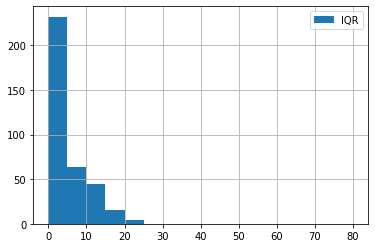

In [103]:
median = math.absences.median()
IQR = math.absences.quantile(0.75) - math.absences.quantile(0.25)
perc25 = math.absences.quantile(0.25)
perc75 = math.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
math.absences.loc[math.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 16, range = (0, 80), label = 'IQR')
plt.legend();

Доверимся царице наук и опустим то, что посчитали выбросами. Не будем учитывать их при анализе критерия пропусков, но оставим в общей выборке, другие данные могут нам пригодится.

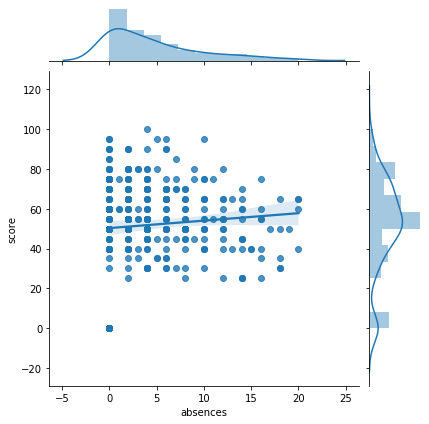

In [104]:
cleaned_absences = math.loc[math.absences <= 20]
sns.jointplot(x='absences', y='score', data=cleaned_absences, kind='reg')

Все равно, выглядит довольно подозрительно. Не должно же количество пропусков улучшать успеваемость.

Попробуем найти связь с другими критериями. 

Причиной пропуска может быть:
* здоровье (health)
* время в пути, ученик опаздывает (travel_time)
* романтические отношения (romantic)

Попробуем разобраться с чем коррелирует колличество пропусков.



In [105]:
math.corr()['absences'].sort_values()

free_time          -0.068436
study_time         -0.065809
family_relations   -0.041958
health             -0.021277
travel_time        -0.014284
score               0.031698
go_out              0.038435
father_education    0.038860
failures            0.068090
mother_education    0.096016
age                 0.171939
absences            1.000000
Name: absences, dtype: float64

Пока что ничего не прояснилось. Может дельнейший анализ прольет свеитна эту загадку.

## Первичный анализ данных в столбцах: категориальные признаки


## `school`
аббревиатура школы, в которой учится ученик

count     387
unique      2
top        GP
freq      343
Name: school, dtype: object
GP    343
MS     44
Name: school, dtype: int64

Неинформативные для критерия "school" записи отсутствуют.


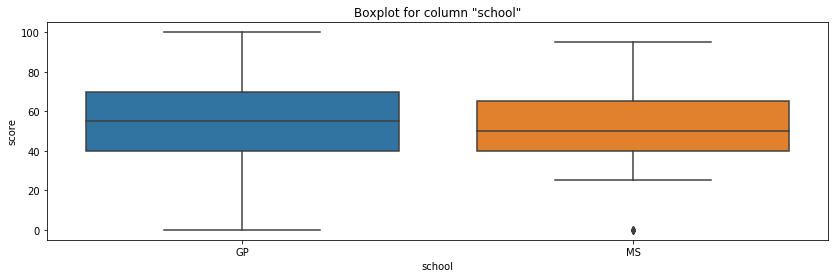

In [106]:
describe_nominal(math.school)

## `sex`
пол ученика ('F' - женский, 'M' - мужской)

Судя по данным большинство учащихся пришли из шеолы GP, остальные из MS


count     387
unique      2
top         F
freq      203
Name: sex, dtype: object
F    203
M    184
Name: sex, dtype: int64

Неинформативные для критерия "sex" записи отсутствуют.


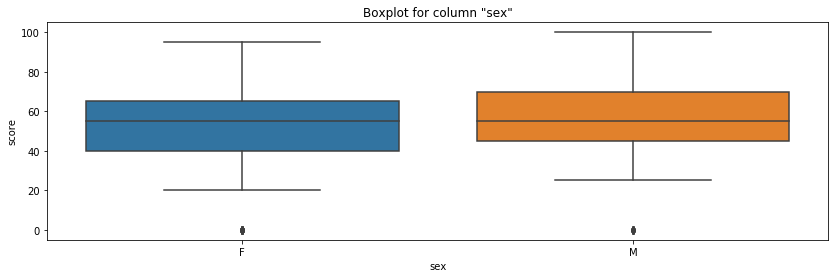

In [107]:
describe_nominal(math.sex)

У нас обучается больше девочек, чем мальчиков, но у мальчиков успеваемость выше.

## `address`
тип адреса ученика ('U' - городской, 'R' - за городом)

count     372
unique      2
top         U
freq      289
Name: address, dtype: object
U    289
R     83
Name: address, dtype: int64

Записи без данных графе "address": 15

Неинформативные для критерия "address" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
52,GP,M,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
75,GP,M,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0
92,GP,F,16,NaN,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
96,GP,M,16,NaN,GT3,NaN,4.0,3.0,services,other,reputation,mother,2.0,1.0,0.0,yes,yes,NaN,yes,no,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
168,GP,F,16,NaN,GT3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,no,yes,yes,no,5.0,1.0,5.0,4.0,0.0,0.0
241,GP,M,17,NaN,LE3,A,4.0,4.0,teacher,other,course,mother,NaN,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,3.0,3.0,NaN,4.0,2.0,60.0
254,GP,M,17,NaN,NaN,T,2.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,no,no,yes,yes,no,4.0,4.0,2.0,5.0,NaN,60.0
292,GP,F,18,NaN,LE3,T,2.0,1.0,services,at_home,reputation,mother,1.0,2.0,1.0,no,NaN,no,no,yes,yes,yes,yes,5.0,4.0,3.0,5.0,12.0,65.0


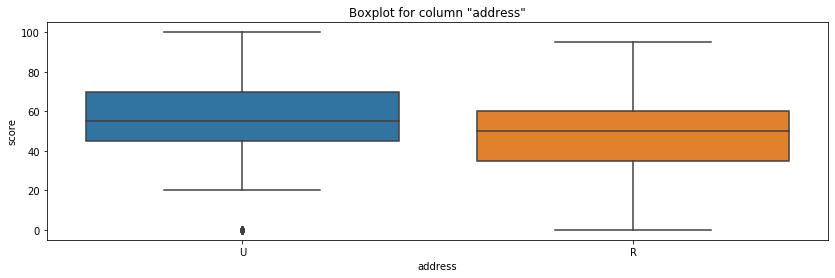

In [108]:
describe_nominal(math.address)

В колонке присутствуют пропуски, заполнить их нет возможности, но и отбрасывать тоже не будем.

Исходя из данных:
* Большинство учащихся - городские
* успеваемость у учащихся живущих в городе - выше.

## `family_size`
размер семьи('LE3' <= 3, 'GT3' >3)

count     360
unique      2
top       GT3
freq      254
Name: family_size, dtype: object
GT3    254
LE3    106
Name: family_size, dtype: int64

Записи без данных графе "family_size": 27

Неинформативные для критерия "family_size" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0
32,GP,M,15,R,NaN,T,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,no,yes,no,yes,NaN,yes,yes,yes,4.0,NaN,2.0,5.0,0.0,80.0
36,GP,M,15,U,NaN,T,4.0,3.0,teacher,services,home,mother,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,4.0,3.0,4.0,2.0,90.0
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
78,GP,M,17,U,NaN,T,2.0,1.0,other,other,home,mother,2.0,1.0,3.0,yes,NaN,no,yes,yes,no,yes,no,4.0,5.0,1.0,3.0,2.0,50.0
79,GP,F,16,U,NaN,T,3.0,4.0,at_home,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,yes,yes,no,2.0,4.0,3.0,3.0,12.0,25.0
114,GP,M,15,R,NaN,T,2.0,1.0,health,services,reputation,mother,1.0,2.0,NaN,no,no,no,yes,yes,yes,yes,yes,5.0,4.0,2.0,5.0,8.0,45.0
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0


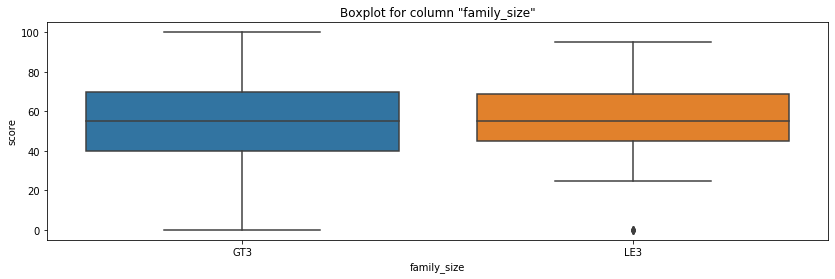

In [109]:
describe_nominal(math.family_size)

В колонке присутствуют пропуски, заполнить их нет возможности, но и отбрасывать тоже не будем.

Так же по данным, приведенным в колонке можно сделать вывод, что большинство семей состоят более чем из 3 человек

## `parents_status`
статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

count     342
unique      2
top         T
freq      307
Name: parents_status, dtype: object
T    307
A     35
Name: parents_status, dtype: int64

Записи без данных графе "parents_status": 45

Неинформативные для критерия "parents_status" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0
11,GP,F,15,U,GT3,NaN,2.0,NaN,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0
15,GP,F,16,U,GT3,NaN,4.0,4.0,health,other,home,mother,1.0,1.0,0.0,no,yes,no,no,yes,yes,yes,no,4.0,4.0,4.0,2.0,4.0,70.0
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,yes,yes,no,NaN,2.0,2.0,5.0,14.0,40.0
28,GP,M,16,U,LE3,NaN,3.0,4.0,services,other,home,mother,1.0,2.0,0.0,yes,NaN,no,yes,yes,yes,yes,no,5.0,3.0,3.0,5.0,4.0,55.0
54,GP,F,15,U,LE3,NaN,3.0,3.0,NaN,other,other,mother,1.0,1.0,NaN,no,no,yes,NaN,yes,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
63,GP,F,16,U,GT3,NaN,4.0,3.0,teacher,health,NaN,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,3.0,4.0,4.0,4.0,2.0,45.0
67,GP,F,16,U,GT3,NaN,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
81,GP,M,15,U,GT3,NaN,2.0,3.0,other,other,home,NaN,1.0,3.0,0.0,yes,no,NaN,NaN,no,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0


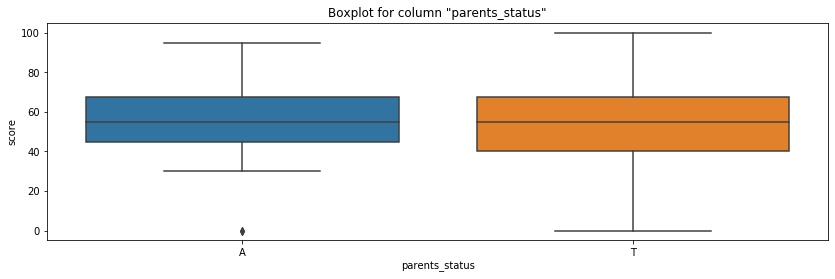

In [110]:
describe_nominal(math.parents_status)

В колонке присутствуют пропуски, заполнить их нет возможности, но и отбрасывать тоже не будем.

Судя по приведенным данным, большинство учащихся живут в полноценных семьях.

## `mother_job`
работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

count       368
unique        5
top       other
freq        127
Name: mother_job, dtype: object
other       127
services     96
at_home      58
teacher      55
health       32
Name: mother_job, dtype: int64

Записи без данных графе "mother_job": 19

Неинформативные для критерия "mother_job" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
29,GP,M,16,U,GT3,T,4.0,4.0,NaN,teacher,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,4.0,4.0,5.0,5.0,16.0,55.0
54,GP,F,15,U,LE3,NaN,3.0,3.0,NaN,other,other,mother,1.0,1.0,NaN,no,no,yes,NaN,yes,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
59,GP,F,16,U,GT3,T,4.0,2.0,NaN,NaN,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0
88,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,reputation,father,2.0,2.0,1.0,no,no,yes,yes,NaN,yes,yes,no,4.0,4.0,2.0,NaN,12.0,50.0
104,GP,M,15,U,GT3,A,3.0,4.0,NaN,other,course,mother,NaN,2.0,0.0,no,yes,NaN,yes,yes,yes,yes,no,5.0,4.0,4.0,1.0,0.0,90.0
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
145,GP,F,15,U,GT3,T,1.0,1.0,NaN,services,course,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,4.0,4.0,2.0,NaN,0.0,55.0
156,GP,M,17,R,LE3,T,1.0,2.0,NaN,other,reputation,mother,1.0,1.0,0.0,no,no,no,no,yes,yes,no,no,2.0,2.0,2.0,5.0,8.0,65.0
166,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,course,father,1.0,2.0,0.0,no,no,no,no,yes,no,yes,no,4.0,3.0,5.0,4.0,4.0,50.0
174,GP,F,16,U,LE3,NaN,3.0,3.0,NaN,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,4.0,4.0,5.0,4.0,4.0,45.0


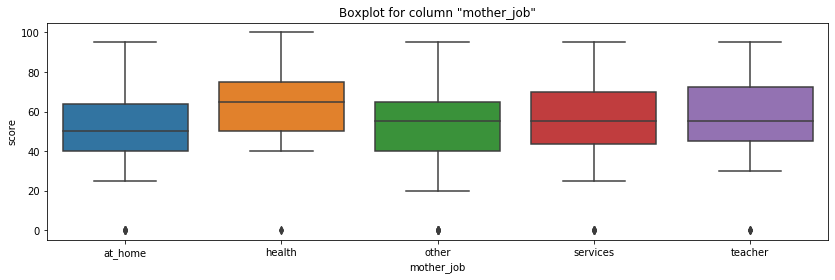

In [111]:
describe_nominal(math.mother_job)

В колонке есть 19 пропусков, а так же 127 записей имеют неинформативное значение 'other' что делает почти половину записей практически бесполезными. 

Судя по графику, наиболее выскоий уровень успеваемости у учащихся, чья мать работает в области здравоохранения.

Как было сказано выше, почти половина записей в колонке неинформативны, поэтому, все же, воздержимся от каких либо выводов на основе этих данных.


## `father_job`
работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

count       351
unique        5
top       other
freq        194
Name: father_job, dtype: object
other       194
services     98
teacher      28
at_home      16
health       15
Name: father_job, dtype: int64

Записи без данных графе "father_job": 36

Неинформативные для критерия "father_job" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
17,GP,F,16,U,GT3,T,3.0,3.0,other,NaN,reputation,mother,3.0,NaN,0.0,yes,NaN,no,yes,yes,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0
22,GP,M,16,U,LE3,T,4.0,2.0,teacher,NaN,course,mother,1.0,2.0,0.0,no,NaN,no,yes,NaN,yes,yes,no,4.0,5.0,1.0,5.0,2.0,80.0
26,GP,M,15,U,GT3,T,2.0,2.0,other,NaN,home,mother,NaN,1.0,0.0,no,yes,NaN,no,yes,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0
31,GP,M,15,U,GT3,T,4.0,4.0,services,NaN,reputation,mother,2.0,2.0,0.0,no,yes,NaN,yes,yes,yes,yes,no,4.0,3.0,1.0,5.0,0.0,85.0
44,GP,F,16,U,LE3,T,2.0,2.0,other,NaN,course,father,2.0,2.0,1.0,yes,no,no,NaN,yes,yes,yes,no,4.0,3.0,3.0,5.0,14.0,45.0
47,GP,M,16,U,GT3,T,4.0,3.0,health,NaN,reputation,mother,1.0,4.0,0.0,no,no,no,yes,yes,yes,yes,no,4.0,2.0,2.0,2.0,4.0,100.0
52,GP,M,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
59,GP,F,16,U,GT3,T,4.0,2.0,NaN,NaN,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,NaN,reputation,mother,NaN,2.0,NaN,yes,yes,NaN,no,yes,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0


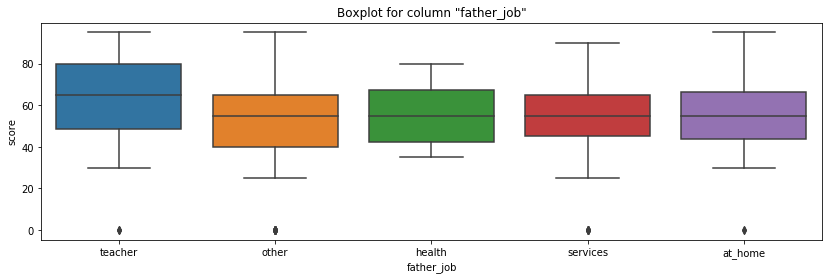

In [112]:
describe_nominal(math.father_job)

В колонке есть 36 пропусков, а так же 194 записи имеют неинформативное значение 'other' что делает почти половину записей практически бесполезными. 

Судя по графику, наиболее выскоий уровень успеваемости у учащихся, чей отец работает учителем.

Как было сказано выше, почти половина записей в колонке неинформативны, поэтому, все же, воздержимся от каких либо выводов на основе этих данных.


## `school_selection_reason`
причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

count        370
unique         4
top       course
freq         134
Name: school_selection_reason, dtype: object
course        134
reputation    102
home          101
other          33
Name: school_selection_reason, dtype: int64

Записи без данных графе "school_selection_reason": 17

Неинформативные для критерия "school_selection_reason" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
33,GP,M,15,U,LE3,T,3.0,3.0,other,other,NaN,mother,1.0,2.0,0.0,no,NaN,no,yes,no,yes,yes,no,5.0,3.0,2.0,2.0,0.0,60.0
63,GP,F,16,U,GT3,NaN,4.0,3.0,teacher,health,NaN,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,3.0,4.0,4.0,4.0,2.0,45.0
73,GP,M,16,U,GT3,T,3.0,1.0,other,other,NaN,mother,1.0,1.0,0.0,no,no,no,yes,yes,yes,no,no,NaN,3.0,2.0,5.0,2.0,70.0
77,GP,F,16,U,GT3,T,2.0,2.0,other,other,NaN,mother,1.0,4.0,0.0,no,no,yes,no,yes,yes,yes,yes,5.0,2.0,3.0,3.0,0.0,55.0
112,GP,F,16,U,GT3,NaN,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,yes,no,no,yes,yes,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
138,GP,M,16,U,LE3,T,1.0,1.0,services,other,NaN,NaN,1.0,2.0,1.0,no,no,no,no,yes,yes,no,yes,4.0,4.0,4.0,5.0,0.0,60.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
185,GP,M,17,U,GT3,T,3.0,3.0,services,services,NaN,mother,1.0,2.0,0.0,no,yes,no,yes,yes,yes,NaN,yes,4.0,3.0,4.0,4.0,12.0,55.0
186,GP,M,16,U,GT3,NaN,1.0,2.0,services,services,NaN,mother,1.0,1.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,3.0,3.0,3.0,2.0,55.0


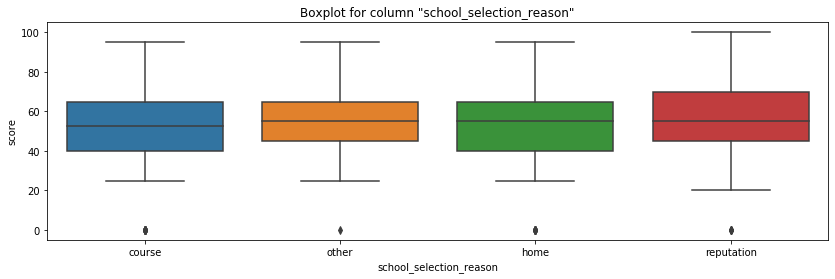

In [113]:
describe_nominal(math.school_selection_reason)

В колонке присутствуют пропуски, заполнить их нет возможности, но и отбрасывать тоже не будем.

Из данных следует:
* большинство учащихся выбирают школу исходя из образовательной программы.
* в то же время для учащихся с более высокой успеваемостью важна, скорее, репутация школы

## `guardian`
опекун ('mother' - мать, 'father' - отец, 'other' - другое)

count        357
unique         3
top       mother
freq         247
Name: guardian, dtype: object
mother    247
father     86
other      24
Name: guardian, dtype: int64

Записи без данных графе "guardian": 30

Неинформативные для критерия "guardian" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
38,GP,F,15,R,GT3,T,3.0,4.0,services,health,course,NaN,1.0,3.0,0.0,yes,NaN,yes,yes,yes,yes,yes,no,4.0,3.0,2.0,5.0,2.0,55.0
41,GP,M,15,U,LE3,T,4.0,4.0,teacher,other,home,NaN,1.0,1.0,0.0,no,yes,no,no,no,yes,yes,NaN,5.0,4.0,3.0,5.0,8.0,60.0
49,GP,F,15,U,GT3,T,4.0,4.0,services,teacher,other,NaN,1.0,2.0,1.0,yes,yes,no,yes,no,yes,yes,no,4.0,4.0,4.0,3.0,2.0,35.0
53,GP,F,15,U,GT3,T,4.0,4.0,services,services,course,NaN,1.0,1.0,0.0,yes,yes,yes,no,yes,yes,yes,no,3.0,3.0,4.0,5.0,0.0,55.0
60,GP,F,16,R,GT3,T,4.0,4.0,health,teacher,other,NaN,1.0,2.0,0.0,no,yes,no,yes,yes,yes,no,no,2.0,4.0,4.0,4.0,6.0,55.0
81,GP,M,15,U,GT3,NaN,2.0,3.0,other,other,home,NaN,1.0,3.0,0.0,yes,no,NaN,NaN,no,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0
90,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,NaN,1.0,3.0,0.0,no,yes,yes,no,yes,yes,yes,yes,4.0,3.0,3.0,4.0,0.0,40.0
98,GP,F,16,U,GT3,T,4.0,4.0,other,other,reputation,NaN,1.0,1.0,0.0,no,NaN,no,yes,no,yes,NaN,no,5.0,3.0,4.0,1.0,6.0,70.0
138,GP,M,16,U,LE3,T,1.0,1.0,services,other,NaN,NaN,1.0,2.0,1.0,no,no,no,no,yes,yes,no,yes,4.0,4.0,4.0,5.0,0.0,60.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,home,NaN,1.0,1.0,3.0,no,yes,no,no,yes,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0


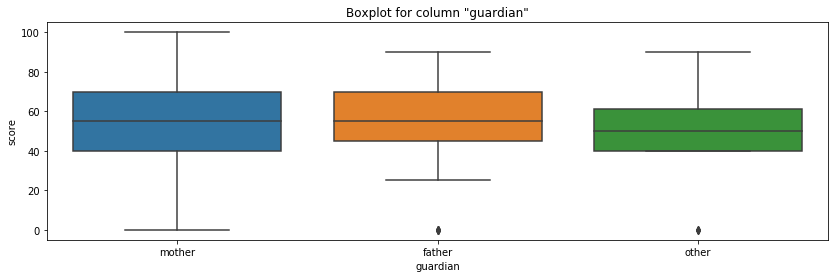

In [114]:
describe_nominal(math.guardian)

В колонке присутствуют пропуски, заполнить их нет возможности, но и отбрасывать тоже не будем.

Из данных следует, что для большинства учащихся опекуном выступает мать. Думаю это объясняет то, что уровеь образования матери влияет на успеваемость больше чем уровеь образования отца.

## `school_support`
дополнительная образовательная поддержка (yes или no)

count     378
unique      2
top        no
freq      330
Name: school_support, dtype: object
no     330
yes     48
Name: school_support, dtype: int64

Записи без данных графе "school_support": 9

Неинформативные для критерия "school_support" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
27,GP,M,15,U,GT3,T,4.0,2.0,health,services,other,mother,1.0,1.0,0.0,NaN,no,yes,no,yes,yes,yes,NaN,2.0,2.0,4.0,1.0,4.0,75.0
35,GP,F,15,U,GT3,T,2.0,3.0,other,other,other,father,NaN,1.0,0.0,NaN,yes,no,yes,yes,yes,no,no,3.0,5.0,1.0,5.0,0.0,30.0
79,GP,F,16,U,NaN,T,3.0,4.0,at_home,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,yes,yes,no,2.0,4.0,3.0,3.0,12.0,25.0
151,GP,M,16,U,LE3,T,2.0,1.0,at_home,NaN,course,mother,1.0,1.0,1.0,NaN,no,no,yes,yes,yes,no,yes,4.0,4.0,4.0,5.0,6.0,70.0
211,GP,M,17,U,LE3,T,4.0,4.0,services,other,home,mother,1.0,2.0,0.0,NaN,yes,yes,no,yes,yes,yes,yes,5.0,3.0,5.0,3.0,13.0,65.0
274,GP,F,17,U,GT3,T,2.0,4.0,at_home,health,reputation,mother,2.0,2.0,0.0,NaN,yes,yes,no,yes,yes,yes,yes,4.0,3.0,3.0,1.0,2.0,50.0
321,GP,F,17,U,GT3,T,2.0,2.0,other,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,yes,no,yes,4.0,2.0,2.0,3.0,12.0,45.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
394,MS,M,19,U,LE3,T,1.0,1.0,other,at_home,NaN,father,1.0,1.0,0.0,NaN,no,no,no,yes,yes,yes,no,3.0,2.0,3.0,5.0,5.0,45.0


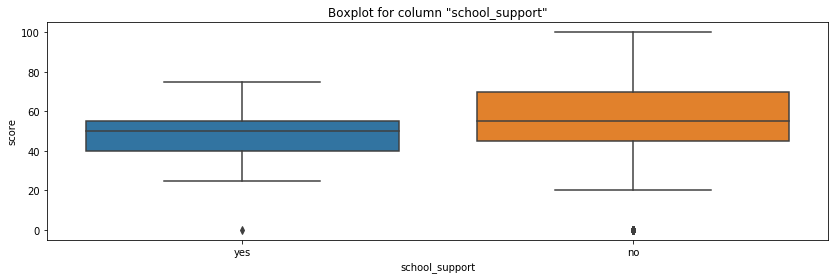

In [115]:
describe_nominal(math.school_support)

В колонке присутствуют пропуски, заполнить их нет возможности, но и отбрасывать тоже не будем.

Из данных следует, что большинство учащихся не пользуются дополнительной образовательной поддержкой, они же имеют более высокий бал на экзамене. Скорее всего к дополнительной образовательной поддержке прибегают в тех случаях, когда нужно "подтянуть" успеваемость, это объясняет более низкий бал у учащихся ответивших положительно.

## `family_support`
семейная образовательная поддержка (yes или no)

count     350
unique      2
top       yes
freq      215
Name: family_support, dtype: object
yes    215
no     135
Name: family_support, dtype: int64

Записи без данных графе "family_support": 37

Неинформативные для критерия "family_support" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
17,GP,F,16,U,GT3,T,3.0,3.0,other,NaN,reputation,mother,3.0,NaN,0.0,yes,NaN,no,yes,yes,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0
22,GP,M,16,U,LE3,T,4.0,2.0,teacher,NaN,course,mother,1.0,2.0,0.0,no,NaN,no,yes,NaN,yes,yes,no,4.0,5.0,1.0,5.0,2.0,80.0
28,GP,M,16,U,LE3,NaN,3.0,4.0,services,other,home,mother,1.0,2.0,0.0,yes,NaN,no,yes,yes,yes,yes,no,5.0,3.0,3.0,5.0,4.0,55.0
33,GP,M,15,U,LE3,T,3.0,3.0,other,other,NaN,mother,1.0,2.0,0.0,no,NaN,no,yes,no,yes,yes,no,5.0,3.0,2.0,2.0,0.0,60.0
38,GP,F,15,R,GT3,T,3.0,4.0,services,health,course,NaN,1.0,3.0,0.0,yes,NaN,yes,yes,yes,yes,yes,no,4.0,3.0,2.0,5.0,2.0,55.0
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
51,GP,F,15,U,LE3,T,4.0,2.0,health,other,other,mother,1.0,2.0,0.0,no,NaN,NaN,no,yes,yes,yes,NaN,4.0,3.0,3.0,5.0,2.0,65.0
52,GP,M,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
59,GP,F,16,U,GT3,T,4.0,2.0,NaN,NaN,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0
61,GP,F,16,U,GT3,T,1.0,1.0,services,services,course,father,4.0,1.0,0.0,yes,NaN,no,yes,no,yes,yes,yes,5.0,5.0,5.0,5.0,6.0,55.0


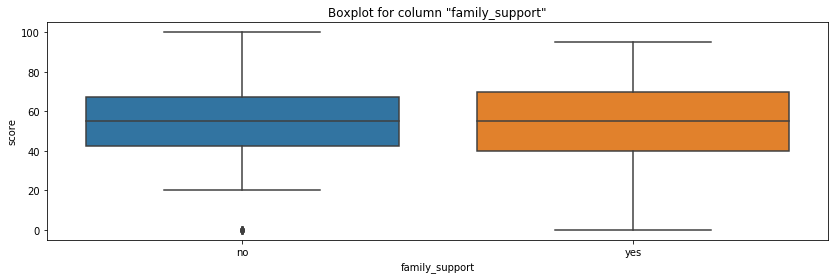

In [116]:
describe_nominal(math.family_support)

В колонке присутствуют пропуски, заполнить их нет возможности, но и отбрасывать тоже не будем.

Исходя их предоставленых данных, большинтво учащихся получает образовательную поддержку дома. 

Глядя на график сложно сделать вывод о влиянии этого критерия на успеваемость, наберемся терпения и подождем более "математических" выводов.

## `paid`
дополнительные платные занятия по математике (yes или no)

count     348
unique      2
top        no
freq      196
Name: paid, dtype: object
no     196
yes    152
Name: paid, dtype: int64

Записи без данных графе "paid": 39

Неинформативные для критерия "paid" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
18,GP,M,17,U,GT3,T,3.0,2.0,services,services,course,mother,1.0,1.0,3.0,no,yes,NaN,yes,yes,yes,yes,no,5.0,5.0,5.0,5.0,16.0,25.0
19,GP,M,16,U,LE3,T,4.0,3.0,health,other,home,father,1.0,1.0,0.0,no,no,NaN,yes,yes,yes,yes,no,3.0,1.0,3.0,5.0,4.0,50.0
21,GP,M,15,U,GT3,T,4.0,NaN,health,health,other,father,1.0,1.0,NaN,no,yes,NaN,no,yes,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
26,GP,M,15,U,GT3,T,2.0,2.0,other,NaN,home,mother,NaN,1.0,0.0,no,yes,NaN,no,yes,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0
31,GP,M,15,U,GT3,T,4.0,4.0,services,NaN,reputation,mother,2.0,2.0,0.0,no,yes,NaN,yes,yes,yes,yes,no,4.0,3.0,1.0,5.0,0.0,85.0
51,GP,F,15,U,LE3,T,4.0,2.0,health,other,other,mother,1.0,2.0,0.0,no,NaN,NaN,no,yes,yes,yes,NaN,4.0,3.0,3.0,5.0,2.0,65.0
57,GP,M,15,U,GT3,T,4.0,NaN,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,NaN,yes,yes,yes,no,no,3.0,2.0,2.0,5.0,4.0,75.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,NaN,reputation,mother,NaN,2.0,NaN,yes,yes,NaN,no,yes,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0
81,GP,M,15,U,GT3,NaN,2.0,3.0,other,other,home,NaN,1.0,3.0,0.0,yes,no,NaN,NaN,no,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0


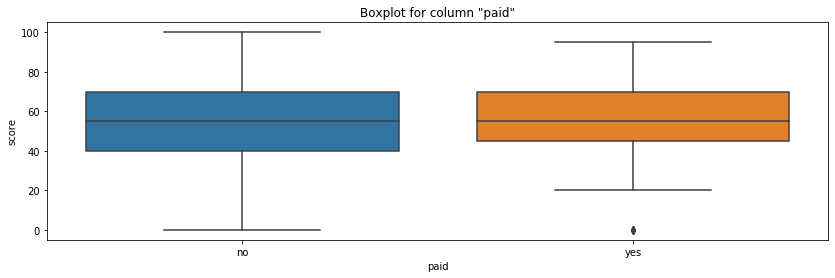

In [117]:
describe_nominal(math.paid)

Глядя на данные, видно, что меньше половины учащихся пользуются услугами репетитора по математике. 

В то же время график показывает, что у тех, кто все же, пользуется, успеваемость выше.

## `activities`
дополнительные внеучебные занятия (yes или no)

count     373
unique      2
top       yes
freq      192
Name: activities, dtype: object
yes    192
no     181
Name: activities, dtype: int64

Записи без данных графе "activities": 14

Неинформативные для критерия "activities" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
43,GP,M,15,U,GT3,T,2.0,2.0,services,services,course,father,1.0,1.0,0.0,yes,yes,no,NaN,yes,yes,yes,no,NaN,4.0,1.0,1.0,0.0,55.0
44,GP,F,16,U,LE3,T,2.0,2.0,other,NaN,course,father,2.0,2.0,1.0,yes,no,no,NaN,yes,yes,yes,no,4.0,3.0,3.0,5.0,14.0,45.0
54,GP,F,15,U,LE3,NaN,3.0,3.0,NaN,other,other,mother,1.0,1.0,NaN,no,no,yes,NaN,yes,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
81,GP,M,15,U,GT3,NaN,2.0,3.0,other,other,home,NaN,1.0,3.0,0.0,yes,no,NaN,NaN,no,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0
99,GP,F,16,U,GT3,T,4.0,3.0,other,at_home,course,mother,1.0,3.0,0.0,yes,yes,yes,NaN,yes,yes,yes,no,5.0,3.0,5.0,3.0,0.0,40.0
116,GP,M,15,U,GT3,T,4.0,4.0,other,teacher,reputation,father,2.0,2.0,0.0,no,yes,no,NaN,yes,yes,no,no,4.0,4.0,3.0,2.0,2.0,70.0
126,GP,F,15,U,LE3,A,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,yes,no,no,NaN,yes,yes,yes,yes,5.0,3.0,2.0,1.0,0.0,55.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
141,GP,M,16,U,LE3,T,2.0,2.0,services,services,reputation,father,2.0,1.0,2.0,no,yes,no,NaN,yes,yes,NaN,no,2.0,3.0,3.0,2.0,8.0,45.0
160,GP,M,17,R,LE3,T,2.0,1.0,at_home,NaN,course,mother,NaN,1.0,2.0,no,no,no,NaN,yes,no,yes,yes,NaN,3.0,2.0,5.0,0.0,0.0


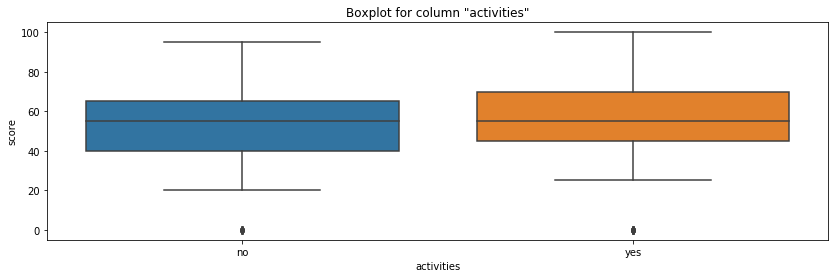

In [118]:
describe_nominal(math.activities)

В колонке присутствуют пропуски, заполнить их нет возможности, но и отбрасывать тоже не будем.

По данным видно, что колличество учащихся имеющих и не имеющих дополнительные занятия кроме школы почти равны.

В тоже время учащиеся давшие утвердительный ответ показывают более высокую успеваемость. Возможно разносторонне развитие положительно влияет на все сферы интересов.

## `nursery`
посещал детский сад (yes или no)

count     372
unique      2
top       yes
freq      295
Name: nursery, dtype: object
yes    295
no      77
Name: nursery, dtype: int64

Записи без данных графе "nursery": 15

Неинформативные для критерия "nursery" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
22,GP,M,16,U,LE3,T,4.0,2.0,teacher,NaN,course,mother,1.0,2.0,0.0,no,NaN,no,yes,NaN,yes,yes,no,4.0,5.0,1.0,5.0,2.0,80.0
32,GP,M,15,R,NaN,T,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,no,yes,no,yes,NaN,yes,yes,yes,4.0,NaN,2.0,5.0,0.0,80.0
85,GP,F,15,U,GT3,T,4.0,4.0,services,services,reputation,father,2.0,2.0,2.0,no,no,yes,no,NaN,yes,yes,yes,4.0,4.0,4.0,5.0,6.0,40.0
88,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,reputation,father,2.0,2.0,1.0,no,no,yes,yes,NaN,yes,yes,no,4.0,4.0,2.0,NaN,12.0,50.0
152,GP,F,15,R,GT3,T,3.0,3.0,services,NaN,reputation,other,2.0,3.0,2.0,no,yes,yes,yes,NaN,yes,yes,yes,4.0,2.0,1.0,3.0,8.0,50.0
212,GP,F,16,U,GT3,A,2.0,2.0,other,other,reputation,mother,1.0,2.0,0.0,yes,yes,yes,NaN,NaN,yes,yes,no,3.0,3.0,4.0,4.0,0.0,70.0
249,GP,M,16,U,GT3,T,0.0,2.0,other,other,other,mother,1.0,1.0,0.0,no,no,yes,no,NaN,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
300,GP,F,18,U,LE3,A,4.0,4.0,health,other,home,mother,1.0,2.0,0.0,no,yes,no,no,NaN,yes,yes,yes,4.0,2.0,4.0,4.0,14.0,55.0
332,GP,F,18,U,GT3,T,3.0,3.0,services,services,home,mother,1.0,2.0,0.0,no,no,no,yes,NaN,yes,yes,no,5.0,3.0,4.0,4.0,0.0,0.0
336,GP,F,19,R,GT3,A,3.0,1.0,services,NaN,home,other,1.0,3.0,1.0,no,no,yes,no,NaN,yes,no,no,5.0,4.0,3.0,5.0,12.0,65.0


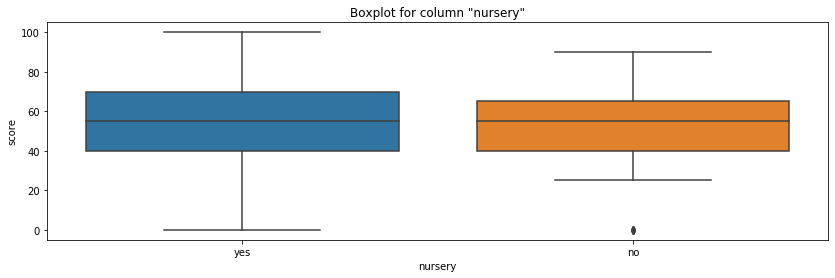

In [119]:
describe_nominal(math.nursery)

В колонке присутствуют пропуски, заполнить их нет возможности, но и отбрасывать тоже не будем.

Данные говорят о том, что подавляющее большинство посещали детский сад.

Уровень успеваемостти так же выше у учащихся посещавших детский сад. Возможно, это вызвано тем, что они более приспособлены к существованию в коллективе и взаимодействию с окружающими.

## `higher`
хочет получить высшее образование (yes или no)

count     367
unique      2
top       yes
freq      348
Name: higher, dtype: object
yes    348
no      19
Name: higher, dtype: int64

Записи без данных графе "higher": 20

Неинформативные для критерия "higher" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
34,GP,M,16,U,GT3,T,3.0,2.0,other,other,home,mother,1.0,1.0,0.0,no,yes,yes,no,no,NaN,yes,no,5.0,4.0,3.0,5.0,0.0,75.0
48,GP,M,15,U,GT3,T,4.0,2.0,teacher,other,home,mother,1.0,2.0,NaN,no,yes,yes,no,yes,NaN,no,no,4.0,3.0,3.0,5.0,2.0,70.0
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
84,GP,F,15,U,GT3,T,1.0,1.0,other,other,home,father,1.0,2.0,0.0,no,yes,no,yes,no,NaN,yes,no,4.0,3.0,2.0,4.0,2.0,50.0
96,GP,M,16,NaN,GT3,NaN,4.0,3.0,services,other,reputation,mother,2.0,1.0,0.0,yes,yes,NaN,yes,no,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0
142,GP,F,15,U,GT3,T,4.0,NaN,teacher,services,course,mother,NaN,3.0,0.0,no,yes,yes,yes,yes,NaN,yes,no,4.0,2.0,2.0,5.0,2.0,55.0
149,GP,M,15,U,LE3,NaN,2.0,1.0,services,other,course,mother,4.0,1.0,3.0,no,NaN,no,no,yes,NaN,yes,no,4.0,5.0,5.0,5.0,0.0,50.0
158,GP,M,16,R,GT3,NaN,2.0,2.0,at_home,other,course,mother,3.0,1.0,NaN,no,no,no,no,no,NaN,no,no,4.0,2.0,2.0,3.0,2.0,75.0
170,GP,M,16,U,GT3,T,3.0,4.0,other,other,course,father,3.0,1.0,NaN,no,yes,no,yes,no,NaN,yes,no,3.0,4.0,5.0,2.0,0.0,0.0
171,GP,M,16,U,GT3,T,1.0,0.0,other,other,reputation,mother,2.0,2.0,NaN,no,yes,yes,yes,yes,NaN,yes,yes,4.0,3.0,2.0,3.0,2.0,80.0


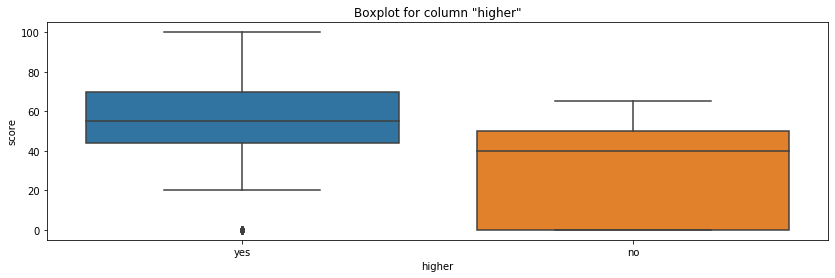

In [120]:
describe_nominal(math.higher)

В колонке присутствуют пропуски, заполнить их нет возможности, но и отбрасывать тоже не будем.

Подавляющее большинство учащихся хочет получить высшее образование и их результаты выше чем у тех, кого вышка не интересует.

## `internet`
наличие интернета дома (yes или no)

count     353
unique      2
top       yes
freq      299
Name: internet, dtype: object
yes    299
no      54
Name: internet, dtype: int64

Записи без данных графе "internet": 34

Неинформативные для критерия "internet" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
12,GP,M,15,U,LE3,T,4.0,4.0,health,services,course,father,1.0,1.0,0.0,no,yes,yes,yes,yes,yes,NaN,no,NaN,3.0,3.0,5.0,2.0,70.0
52,GP,M,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
65,GP,F,16,U,LE3,T,4.0,3.0,teacher,services,course,mother,3.0,2.0,0.0,no,yes,no,yes,yes,yes,NaN,no,5.0,4.0,3.0,1.0,2.0,75.0
80,GP,M,15,U,GT3,T,2.0,3.0,other,services,course,father,1.0,1.0,0.0,yes,yes,yes,yes,no,yes,NaN,yes,3.0,2.0,2.0,3.0,2.0,60.0
86,GP,F,16,U,LE3,T,2.0,2.0,at_home,other,course,mother,1.0,2.0,0.0,no,yes,no,no,yes,yes,NaN,no,4.0,3.0,4.0,2.0,4.0,30.0
98,GP,F,16,U,GT3,T,4.0,4.0,other,other,reputation,NaN,1.0,1.0,0.0,no,NaN,no,yes,no,yes,NaN,no,5.0,3.0,4.0,1.0,6.0,70.0
110,GP,M,15,U,LE3,A,4.0,4.0,teacher,teacher,course,mother,1.0,1.0,0.0,no,no,no,yes,yes,yes,NaN,no,5.0,5.0,3.0,4.0,6.0,95.0
115,GP,M,16,U,GT3,T,4.0,4.0,teacher,teacher,course,father,1.0,2.0,NaN,no,yes,no,yes,yes,yes,NaN,no,5.0,4.0,4.0,5.0,2.0,80.0
117,GP,M,16,U,GT3,T,3.0,3.0,other,services,home,father,2.0,1.0,0.0,no,no,no,yes,yes,yes,NaN,no,5.0,4.0,2.0,5.0,0.0,65.0


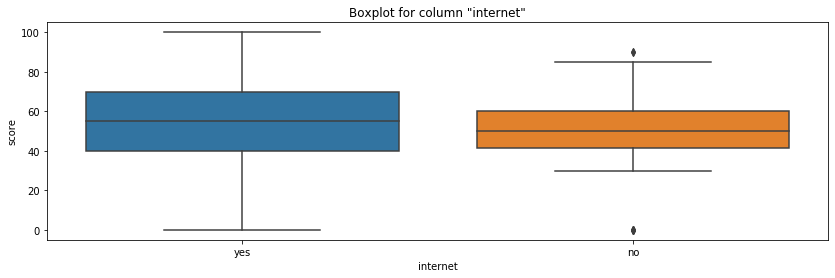

In [121]:
describe_nominal(math.internet)

В колонке присутствуют пропуски, заполнить их нет возможности, но и отбрасывать тоже не будем.

Как мы видим, большинство учащихся имеют доступ к интернету и это явно помогает им в обучении ведь их балл на экзамене выше.

## `romantic`
в романтических отношениях (yes или no)


count     356
unique      2
top        no
freq      233
Name: romantic, dtype: object
no     233
yes    123
Name: romantic, dtype: int64

Записи без данных графе "romantic": 31

Неинформативные для критерия "romantic" записи:


,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,school_selection_reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,free_time,go_out,health,absences,score
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
13,GP,M,15,U,GT3,T,4.0,3.0,teacher,other,course,mother,2.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,NaN,5.0,4.0,3.0,3.0,2.0,55.0
26,GP,M,15,U,GT3,T,2.0,2.0,other,NaN,home,mother,NaN,1.0,0.0,no,yes,NaN,no,yes,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0
27,GP,M,15,U,GT3,T,4.0,2.0,health,services,other,mother,1.0,1.0,0.0,NaN,no,yes,no,yes,yes,yes,NaN,2.0,2.0,4.0,1.0,4.0,75.0
41,GP,M,15,U,LE3,T,4.0,4.0,teacher,other,home,NaN,1.0,1.0,0.0,no,yes,no,no,no,yes,yes,NaN,5.0,4.0,3.0,5.0,8.0,60.0
51,GP,F,15,U,LE3,T,4.0,2.0,health,other,other,mother,1.0,2.0,0.0,no,NaN,NaN,no,yes,yes,yes,NaN,4.0,3.0,3.0,5.0,2.0,65.0
54,GP,F,15,U,LE3,NaN,3.0,3.0,NaN,other,other,mother,1.0,1.0,NaN,no,no,yes,NaN,yes,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
67,GP,F,16,U,GT3,NaN,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
75,GP,M,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0
112,GP,F,16,U,GT3,NaN,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,yes,no,no,yes,yes,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0


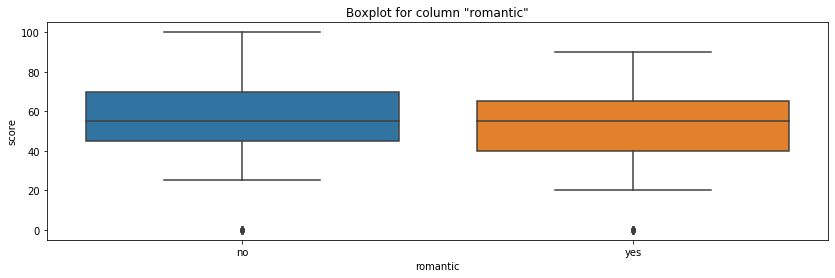

In [122]:
describe_nominal(math.romantic)

Судя по данным лишь треть опрошенных состоит в романтических отношения и, судя по графиу, это не лучшим способом влияет на их успеваемость.

# Выбор критериев для модели.

После завршения первичного анализа даных перейдем к віделению критериев для обучения модели.

## Корелляционный анализ числовых признаков.

Выявим чысловые признаки, оказывающие наибольшее влияние на конечный балл учащегося.

Создадим дополнительный датасет с данными корелляционного анализа:

In [123]:
corr = pd.DataFrame(math.corr()['score'])
corr = corr.loc[corr['score'] != 1]
corr.reset_index()

# Добавми столбец с со значением коэфициента корелляции по модулю для облегчения сравнения.
corr = corr.assign(abs_score = lambda x: abs(x['score']))

## Отберем критерии, чей коефициент по модулю больше 0.1
abs_scores = corr.loc[corr['abs_score'] >= .1].sort_values(by='abs_score', ascending=False)
display(abs_scores)

,score,abs_score
failures,-0.344276,0.344276
mother_education,0.216238,0.216238
age,-0.153488,0.153488
father_education,0.128302,0.128302
go_out,-0.122992,0.122992
study_time,0.116202,0.116202


После анализа числовых критериев мы видим следующую картину:

На успеваемость  сильнее всего влияют следующие критерии:
* количество внеучебных неудач (failures), чем больше неудачь тем ниже балл на экзамене 
* образование матери (mother_education), чем выше образование тем выше балл. Важность этого критерия увеличивает тот факт, что для большинства учащихся опекуном является именно мать.
* возраст ученика (age) - влияет отрицательно: c возрастом балл падает
* образование отца (father_education) - влияет положительно
* проведение времени с друзьями (go_out) - влияет отрицательно
* время на учёбу помимо школы в неделю (study_time) - влияет положительно

In [124]:
model_cols = model_cols = abs_scores.index.tolist()
print('Отобранные для обучения модели столбцы: ', model_cols)

Отобранные для обучения модели столбцы:  ['failures', 'mother_education', 'age', 'father_education', 'go_out', 'study_time']


## Анализ категориальных признаков.

Выявим категориальные признаки, оказывающие наибольшее влияние на конечный балл учащегося.

Для этого воспользуемся тестом Стьюдента

In [125]:
selected_columns = {}
def get_stat_dif(column):
    cols = math.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        ttest = ttest_ind(math.loc[math.loc[:, column] == comb[0], 'score'],
                          math.loc[math.loc[:, column] == comb[1], 'score']).pvalue
        if ttest<= 0.05/len(combinations_all): 
            print('Найдены статистически значимые различия для колонки "{}" ({})'.format(column, ttest))
            selected_columns[column] = ttest
            break

for col in nominative_columns:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки "sex" (0.04048288371142585)
Найдены статистически значимые различия для колонки "address" (0.02182119648668348)
Найдены статистически значимые различия для колонки "mother_job" (0.00422182882401537)
Найдены статистически значимые различия для колонки "higher" (0.0003556761741704713)
Найдены статистически значимые различия для колонки "romantic" (0.008306133540669456)


Отсортируем результаты и выведем более наглядном виде.

In [126]:
sorted_selected_columns = sorted(selected_columns.items(), key=lambda x: x[1], reverse=True)

for col in sorted_selected_columns:
    get_boxplot(col[0], col[1])
    

NameError: name 'get_boxplot_' is not defined

После анализа категориальных критериев мы видим следующую картину:

На успеваемость сильнее всего влияют следующие критерии: 
* пол ученика (sex) - у мальчиков успеваемость выше
* тип адреса ученика (address) - ученики живущие в городе показывают более высокий результат на екзамене
* состоит ли ученик в романтических отношениях (romantic) - у учещихся не состоящих в отношениях балл на екзамене выше
* работа матери (mother_job) - учащиесь неуказавшие кем работает мать либо указавшие в этой графе 'other' показывают результат хуже, чем укзавшие конкретный вид деятельности.
* хочет получить высшее образование (higher) - ученики желающие получить высшее образование более успешни на экзамене

In [67]:
model_cols.extend([col[0] for col in sorted_selected_columns])
print(model_cols)

['failures', 'mother_education', 'age', 'father_education', 'go_out', 'study_time', 'sex', 'address', 'romantic', 'mother_job', 'higher', ['sex', 'address', 'romantic', 'mother_job', 'higher'], 'sex', 'address', 'romantic', 'mother_job', 'higher']


# Итоги
Проанализировав предоставленный датасет мы приходим ка следующим выводам:

## Качество данных

### Пропуски

Многие столбцы содержат отсутствующие данныедля большинства столбцов количество таких записей не превышает 10%

Лишь два столбца имеют более 10% пустых значений это:
* paid (10.1)
* parents_status (11.4)

Для данного датасета не было достаточных оснований для выбора значения, которое бы использовалось для замены пустых значений. Было принято решение не заполнять их но и не удалять из общей выборки.

### Пропуски в столбце `score`

Так же датасет содержит 37 записе (9.51% от всего датасета) со значением 0 баллов в столбце score который является ключевым для нас.
Это могут быть люди неявившиесь или недопущеные к экзамену либо ошибки ввода.
Как интерпритировать эти данные непонятно.

### Выбросы

Выбросы наблюдались в следующих столбцах:

`father_education` 

Встретился выброс со значением 40.
При детальном рассмотрении видно, что остальные поля заполнены правильно. Будем считать это опечаткой, и зполним значением NaN. Есть шанс, что хотели написать 4, а получилось 40, но достоверно сказать этого нельзя.

`family_relations`

Встретился выброс со значением -1.
Остальные поля заполнены нормально, удалять запись смысла не вижу. Будем считать это опечаткой, и зполним значением NaN.

`absences`

Вот эта колонка вызвала много вопросов.
Было два явных выброса со значениями 385 и 212 и результатом в 85 и 45 быллов соответственно. Это не свойственно для данной выборки и очень сильно влияет на результаты исследования. Выбросы были удалены из выборки.

Даже после удаления явных выбросов и расчета границ распределения, колонка выглядит довольно подозрительно. Не должно же количество пропусков улучшать успеваемость.

## Выбранные критерии

На успеваемость сильнее всего влияют следующие критерии:
* количество внеучебных неудач (failures), чем больше неудачь тем ниже балл на экзамене
* образование матери (mother_education), чем выше образование тем выше балл. Важность этого критерия увеличивает тот факт, что для большинства учащихся опекуном является именно мать.
* возраст ученика (age) - влияет отрицательно: c возрастом балл падает
* образование отца (father_education) - влияет положительно
* проведение времени с друзьями (go_out) - влияет отрицательно
* время на учёбу помимо школы в неделю (study_time) - влияет положительно
* пол ученика (sex) - у мальчиков успеваемость выше
* тип адреса ученика (address) - ученики живущие в городе показывают более высокий результат на екзамене
* состоит ли ученик в романтических отношениях (romantic) - у учещихся не состоящих в отношениях балл на екзамене выше
* работа матери (mother_job) - учащиесь неуказавшие кем работает мать либо указавшие в этой графе 'other' показывают результат хуже, чем укзавшие конкретный вид деятельности.
* хочет получить высшее образование (higher) - ученики желающие получить высшее образование более успешни на экзамене